# TWEETS CLASSIFICATION

https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

# Import data

In [2]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import re
import spacy

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [4]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, string#, textblob
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

Using TensorFlow backend.


In [5]:
os.listdir()

['.ipynb_checkpoints',
 'sample_submission.csv',
 'sentiment140_160k_tweets_train.csv',
 'sentiment140_test.csv',
 'Tweets Classification.ipynb']

In [6]:
# Import train test
train = pd.read_csv('sentiment140_160k_tweets_train.csv')
test = pd.read_csv('sentiment140_test.csv')

In [7]:
train.head()

,target,ids,user,text
0,p,1978186076,ceruleanbreeze,"@nocturnalie Anyway, and now Abby and I share ..."
1,p,1994697891,enthusiasticjen,@JoeGigantino Few times I'm trying to leave co...
2,p,2191885992,LifeRemixed,@AngieGriffin Good Morning Angie I'll be in t...
3,p,1753662211,lovemandy,"had a good day driving up mountains, visiting ..."
4,p,2177442789,_LOVELYmanu,downloading some songs i love lady GaGa.


In [8]:
test.head()

,ids,user,text
0,1966755320,dbuie,my twitter is dead where did everybody go @T_...
1,1676776141,MissTierra,@theasiangoddess OUCH! that really looks like ...
2,2052521105,CaliBelle,@3fingaz I cant read it frm ma phone
3,1956499203,extraorDANaire1,Never go clubbing with a couple...you'll only ...
4,1880896910,dinnie,Not to advertise. But www.funzsquare.com is my...


In [9]:
# nb of tweet per user
train[['text','user']].groupby(['user']).count().sort_values('text',ascending = False).head(15)

,text
user,
lost_dog,55
mcraddictal,33
webwoke,33
tweetpet,33
SallytheShizzle,29
enamoredsoul,28
DarkPiano,27
VioletsCRUK,27
what_bugs_u,26


In [10]:
train[['text','user']].groupby(['user']).count().sort_values('text',ascending = False).count()

text    123402
dtype: int64

In [11]:
train.shape[0]

159985

In [12]:
train['target'].unique()

array(['p', 'n'], dtype=object)

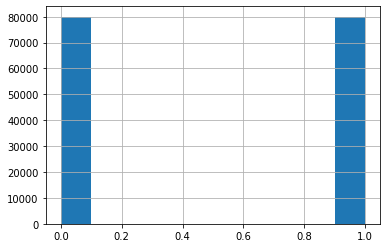

In [13]:
targetMAP = {'p':1, 'n':0}
train['target_bool'] = train['target'].map(targetMAP)
train = train.drop('target',1)
train['target_bool'].hist()

In [14]:
train.head()

,ids,user,text,target_bool
0,1978186076,ceruleanbreeze,"@nocturnalie Anyway, and now Abby and I share ...",1
1,1994697891,enthusiasticjen,@JoeGigantino Few times I'm trying to leave co...,1
2,2191885992,LifeRemixed,@AngieGriffin Good Morning Angie I'll be in t...,1
3,1753662211,lovemandy,"had a good day driving up mountains, visiting ...",1
4,2177442789,_LOVELYmanu,downloading some songs i love lady GaGa.,1


# Pre processing

## Text cleaning

### Examples

I have to clean the text, get rid of useless words and tipos

https://www.pythonforbeginners.com/regex/regular-expressions-in-python

https://python-django.dev/page-expressions-regulieres-regular-python

In [15]:
# mentions : if a specific mention contains only positive tweets the feature might be added in the model...
text = re.sub(r'@\w+', '', train['text'][0])

In [16]:
print(train['text'][0])
print(text)

@nocturnalie Anyway, and now Abby and I share all our crops. We have a very healthy Master/Minion relationship 
 Anyway, and now Abby and I share all our crops. We have a very healthy Master/Minion relationship 


In [17]:
ex2 = 'hello visit the website: https://youyou.fr'

# urls : do not bring predictive power to the model
text2 = re.sub(r'http.?://[^/s]+[/s]?', '', ex2)

In [18]:
print(ex2)
print(text2)

hello visit the website: https://youyou.fr
hello visit the website: 


In [19]:
ex3 = 'i like1 2 3 #wow'

## let's remove symbols and digits as well
text3 = re.sub('[^a-zA-Z\s]', '', ex3)

In [20]:
print(ex3)
print(text3)

i like1 2 3 #wow
i like   wow


In [21]:
ex4 = '   wow il  fait beau   '

# remove extra spaces
text4 = re.sub("\s+", '', ex4)
# remove leading spaces
text5 = ex4.lstrip()
# remove trailing spaces
text6 = ex4.rstrip()

text7 = text4.lstrip().rstrip()

In [22]:
print(ex4)
print(f'remove extra spaces   : [{text4}]')
print(f'remove leading spaces : [{text5}]')
print(f'remove trailing spaces: [{text6}]')
print(f'remove all spaces     : [{text7}]')

   wow il  fait beau   
remove extra spaces   : [wowilfaitbeau]
remove leading spaces : [wow il  fait beau   ]
remove trailing spaces: [   wow il  fait beau]
remove all spaces     : [wowilfaitbeau]


In [23]:
ex5 = 'EdLo L Ik kO LLL'

# only lower char
text8 = ex5.lower()

In [24]:
print(ex5)
print(text8)

EdLo L Ik kO LLL
edlo l ik ko lll


Also, using a spell checker to correct mistakes

https://norvig.com/spell-correct.html?source=post_page---------------------------

## Defining a Custom Transformer

In [25]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http.?://[^/s]+[/s]?', '', text)
    text = re.sub('[^a-zA-Z\s]', '', text)
    return text.strip().lower()

# Tokenisation

In [28]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [29]:
# run in shell : python -m spacy download en

# Create our list of punctuation marks
punctuations = string.punctuation

print(punctuations, '\n')

# Create a list of stopwords
# nlp = spacy.load('en')
# print(nlp, '\n')

stop_words = spacy.lang.en.stop_words.STOP_WORDS
print(stop_words, '\n')

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Create a tokenizer function
def spacy_tokenizer(sentence):
    # Create a token object, used to create documents with linguistic annotations
    mytokens = parser(sentence)
    
    # Lemmatizing each token
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != '-PRON-' else word.lower_ for word in mytokens]
    
    # Removing stopwords and punctuations
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations]
    
    return(mytokens)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 

{'himself', 'a', 'his', 'thereupon', 'the', 'often', 'most', 'thereafter', 'however', 'other', '‘s', 'on', 'several', 'whence', 'has', 'becomes', 'used', 'for', 'thence', 'again', 'whereupon', 'does', 'thru', 'sixty', 'eight', 'still', 'two', 'herein', 'nevertheless', 'until', 'n’t', 'otherwise', 'although', 'over', 'not', 'can', '’ve', 'less', 'be', 'name', 'third', 'three', 'each', 'yourselves', 'this', 'also', 'various', 'was', 'afterwards', 'fifteen', 'only', 'had', 'almost', 'should', 'who', 'somewhere', '’d', 'forty', 'hence', 'do', 'at', 'when', 'one', "'ll", 'here', 'such', 'or', 'ourselves', 'more', 'put', 'formerly', 'anyone', 'already', 'noone', 'did', 'onto', 're', "'ve", 'we', 'if', 'but', 'twenty', 'whole', 'because', 'back', 'side', 'what', 'then', 'someone', 'he', 'another', 'as', 'during', '’ll', 'elsewhere', 'which', '‘re', 'last', 'become', 'give', 'ten', 'seems', 'to', 'where', 'ca', 'well', 'there', 'some', 'five', 'an', 'anyhow',

In [30]:
spacy_tokenizer(train.loc[1,'text'])

['@joegigantino',
 'time',
 'try',
 'leave',
 'comment',
 'blog',
 'message',
 'quot;operation',
 'aborted&quot',
 'clue']

## Vectorization Feature Engineering (TF-IDF)

Classifying text in positive and negative labels is called sentiment analysis. So we need a way to represent our text numerically.

One tool we can use for doing this is called Bag of Words. BoW converts text into the matrix of occurrence of words within a given document. It focuses on whether given words occurred or not in the document, and it generates a matrix that we might see referred to as a BoW matrix or a document term matrix.

In [31]:
# ngram_range is lower and upper range of the context
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,5))
print(bow_vector)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 5), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x000001B0D9128048>,
                vocabulary=None)


$$Term Frequency-Inverse Document Frequency$$


$$ idf(W) = \frac{nb\_documents}{nb\_documents\_containing\_word\_W} $$

a way of normalizing our Bag of Words(BoW) by looking at each word’s frequency in comparison to the document frequency. In other words, it’s a way of representing how important a particular term is in the context of a given document, based on how many times the term appears and how many other documents that same term appears in. The higher the TF-IDF, the more important that term is to that document.

In [32]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)
print(tfidf_vector)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x000001B0D9128048>,
                use_idf=True, vocabulary=None)


## Validation

In [33]:
from sklearn.model_selection import train_test_split
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(train['text'], train['target_bool'])

In [34]:
bow_vector.fit(train['text'])

# transform the training and validation data using count vectorizer object
X_train_v_count =  bow_vector.transform(X_train_v)
X_test_v_count =  bow_vector.transform(X_test_v)

In [35]:
# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_train_v), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_test_v), maxlen=70)

NameError: name 'token' is not defined

In [58]:
import tqdm

100%|████████████████████████████████████████████████████████████████████████| 159985/159985 [1:36:13<00:00, 27.71it/s]


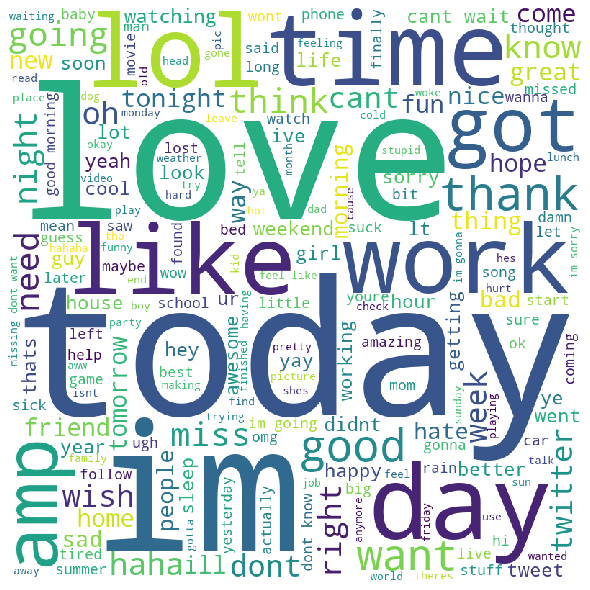

In [59]:
# Python program to generate WordCloud 
import tqdm

# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

comment_words = ' '

# iterate through the csv file 
for val in tqdm.tqdm(train['text']):

    # typecaste each val to string 
    val = clean_text(val)

    # split the value 
    tokens = val.split() 

    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop_words, min_font_size = 10).generate(comment_words) 

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


## Splitting The Data into Training and Test Sets

In [31]:
# X_train = train['text']
# y_train = train['target_bool']

# X_test = test['text']

## Creating a Pipeline and Generating the Model

In [36]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return(metrics.accuracy_score(predictions, y_test_v),metrics.precision_score(predictions, y_test_v),metrics.recall_score(predictions, y_test_v))

### Naive bayes

In [37]:
tfidf_vector.fit(train['text'])
xtrain_tfidf =  tfidf_vector.transform(X_train_v)
xvalid_tfidf =  tfidf_vector.transform(X_test_v)

In [38]:
# Naive Bayes on Ngram Level TF IDF Vectors
results_nb = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train_v, xvalid_tfidf)
print(f'Accuracy Naive Bayes: {results_nb[0]}\nPrecision Naive Bayes: {results_nb[1]}\nRecall Naive Bayes: {results_nb[2]}\n')

Accuracy Naive Bayes: 0.7350551291346851
Precision Naive Bayes: 0.6785036459894116
Recall Naive Bayes: 0.7655677655677655



### Logistic Reg

In [39]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create a pipeline using BoW
pipe = Pipeline([('cleaner', predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# Model generation
pipe.fit(X_train_v, y_train_v)

C:\Users\PC\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x000001B082A63CF8>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 5), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x000001B0D9128048>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_

#### Evaluating the Model

In [40]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test_v)

In [ ]:
# # Model Accuracy on train
# print("Logistic Regression Accuracy LR:",metrics.accuracy_score(y_test_v, predicted))
# print("Logistic Regression Precision LR:",metrics.precision_score(y_test_v, predicted))
# print("Logistic Regression Recall LR:",metrics.recall_score(y_test_v, predicted))

In [41]:
# LR on Ngram Level TF IDF Vectors
print(f"Accuracy Logistic Regression: {metrics.accuracy_score(y_test_v, predicted)}\nPrecision Logistic Regression: {metrics.precision_score(y_test_v, predicted)}\nRecall Logistic Regression: {metrics.recall_score(y_test_v, predicted)}\n")

Accuracy Logistic Regression: 0.7527064529839738
Precision Logistic Regression: 0.7412947172867146
Recall Logistic Regression: 0.7772450304664869



### RF

In [42]:
# RF on Count Vectors
results_rf = train_model(ensemble.RandomForestClassifier(), X_train_v_count, y_train_v, X_test_v_count)
print(f"Accuracy RF: {results_rf[0]}\nPrecision RF: {results_rf[1]}\nRecall RF: {results_rf[2]}\n")

C:\Users\PC\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy RF: 0.7079030927319548
Precision RF: 0.6791029867146139
Recall RF: 0.7211349774595598



### XGB

In [43]:
import xgboost as xgb

In [44]:
# Extereme Gradient Boosting on Count Vectors
results_xgb = train_model(xgb.XGBClassifier(), X_train_v_count.tocsc(), y_train_v, X_test_v_count.tocsc())
print(f"Accuracy XGB: {results_xgb[0]}\nPrecision XGB: {results_xgb[1]}\nRecall XGB: {results_xgb[2]}\n")

Accuracy XGB: 0.6758256869265195
Precision XGB: 0.8754370192787934
Recall XGB: 0.626



### NN

In [ ]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer = optimizers.Adam(), loss = 'binary_crossentropy')
    return(classifier)

In [ ]:
classifier = create_model_architecture(xtrain_tfidf.shape[1])
results_nn = train_model(classifier, xtrain_tfidf, y_train_v, xvalid_tfidf, is_neural_net=True)

In [47]:
print(f"Accuracy NN: {results_nn[0]}\nPrecision NN: {results_nn[1]}\nRecall NN: {results_nn[2]}\n")

Accuracy NN: 0.4994124559341951
Precision NN: 0.0
Recall NN: 0.0



### DCNN

In [49]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
results_cnn = train_model(classifier, train_seq_x, y_train_v, valid_seq_x, is_neural_net=True)
print(f"Accuracy CNN: {results_nn[0]}\nPrecision CNN: {results_nn[1]}\nRecall CNN: {results_n[2]}\n")

NameError: name 'word_index' is not defined

### LSTM

In [ ]:
def create_rnn_lstm():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_lstm()
results_lstm = train_model(classifier, train_seq_x, y_train_v, valid_seq_x, is_neural_net=True)
print(f"Accuracy LSTM: {results_lstm[0]}\nPrecision CNN: {results_lstm[1]}\nRecall CNN: {results_lstm[2]}\n")

# Save file

In [42]:
# Create result dataframe
d = {'target': predicted, 'ids': test['ids']}
results = pd.DataFrame(data = d)

In [52]:
predict_reMAP = {1:'p', 0:'n'}
results['target'] = results['target'].map(predict_reMAP)

In [53]:
# Save file
results.to_csv('results.csv', index = False)